In [57]:
from neo4j import GraphDatabase
from neo4j.types.graph import Node, Relationship
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def graph_from_cypher(data):
    """Constructs a networkx graph from the results of a neo4j cypher query.
    Example of use:
    >>> result = session.run(query)
    >>> G = graph_from_cypher(result.data())

    Nodes have fields 'labels' (frozenset) and 'properties' (dicts). Node IDs correspond to the neo4j graph.
    Edges have fields 'type_' (string) denoting the type of relation, and 'properties' (dict)."""

    G = nx.MultiDiGraph()
    def add_node(node):
        # Adds node id it hasn't already been added
        u = node.id
        if G.has_node(u):
            return
        G.add_node(u, labels=node._labels, properties=dict(node))

    def add_edge(relation):
        # Adds edge if it hasn't already been added.
        # Make sure the nodes at both ends are created
        for node in (relation.start_node, relation.end_node):
            add_node(node)
        # Check if edge already exists
        u = relation.start_node.id
        v = relation.end_node.id
        eid = relation.id
        if G.has_edge(u, v, key=eid):
            return
        # If not, create it
        G.add_edge(u, v, key=eid, type_=relation.type, properties=dict(relation))

    for d in data:
        for entry in d.values():
            # Parse node
            if isinstance(entry, Node):
                add_node(entry)

            # Parse link
            elif isinstance(entry, Relationship):
                add_edge(entry)
            else:
                raise TypeError("Unrecognized object")
    return G

driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "1111"))

query = """
START n=node(*) MATCH (n)-[r]->(m) RETURN n,r,m;
"""

with driver.session() as session:
    result = session.run(query)

# This works
G = graph_from_cypher(result.data())

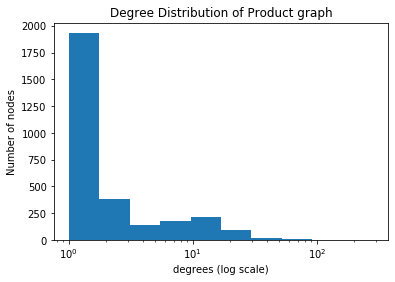

In [79]:
import math
import numpy as np
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    hist, bins = np.histogram(degrees, bins=10)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(degrees, bins=logbins)
    plt.title('Degree Distribution of Product graph')
    plt.xscale('log')
    plt.ylabel('Number of nodes')
    plt.xlabel('degrees (log scale)')
    plt.show()

plot_degree_dist(G)

In [59]:
G.number_of_nodes()

2960

In [60]:
G.number_of_edges()

5289

C:\Users\super\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show(*args, **kw)>

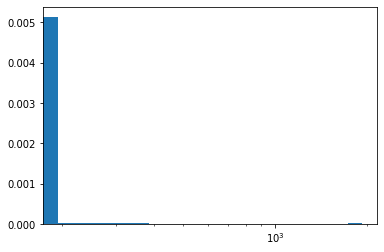

In [85]:
plt.hist(nx.degree_histogram(G),normed=1)
plt.xscale('log')
plt.show